# Laboratory #3 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost 
*   Face recognition
    *   Eigen Faces
    *   PCA and LDA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [14]:
# mount drive to the notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Face Detection using AdaBoost

In [1]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import data, io
import os
import matplotlib 
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
import skimage

### Exercise #1

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [5]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on the original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    print(integral_image_arr)
    
    # Add code here

    height = len(img_arr)
    width = len(img_arr[0])
    print(height)
    print(width)
    j=0
    i=0
    for i in range(height): 
      for j in range(width):
          integral_image_arr[i+1,j+1] = np.sum(img_arr[:i+1,:j+1])
    return integral_image_arr


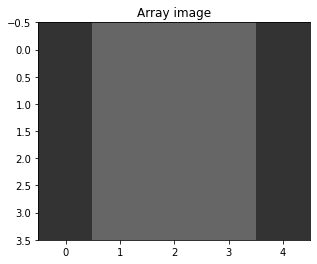

In [3]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.title("Array image")
plt.show()


In [6]:
ii_img_array = compute_integral_image(img_array)
print(ii_img_array)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
4
5
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
512
512


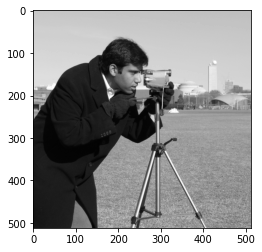

<function matplotlib.pyplot.show>

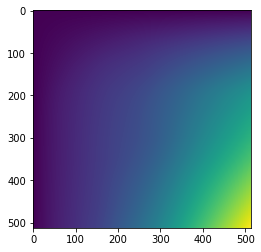

In [7]:
# solution
img= data.camera()
#img = rgb2gray(img)
integral_img = compute_integral_image(img)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(integral_img)
plt.show

### Exercise #2

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [8]:
def sum_region(integral_img_arr, top_left, bottom_right):

    
    # Add code here
    cornerTopLeft = integral_img_arr[top_left[0],top_left[1]]
    cornerTopRight = integral_img_arr[top_left[0],bottom_right[1]]
    cornerBottonRight = integral_img_arr[bottom_right[0],bottom_right[1]]
    cornerBottonLeft = integral_img_arr[bottom_right[0],top_left[1]]

    sum_region =  cornerBottonRight - cornerTopRight - (cornerBottonLeft-cornerTopLeft) 
    return sum_region

In [9]:
def sum_region(integral_img_arr, top_left, bottom_right):
  
    top_left_sum = integral_img_arr[top_left[0], top_left[1]]
    bottom_right_sum = integral_img_arr[bottom_right[0], bottom_right[1]]
    bottom_left_sum = integral_img_arr[bottom_right[0], top_left[1]]
    top_right_sum = integral_img_arr[top_left[0], bottom_right[1]]
    return bottom_right_sum - top_right_sum - (bottom_left_sum - top_left_sum)

*   Make the following tests:

In [ ]:
# result you should get (12)
print(sum_region(ii_img_array, [1, 1], [3, 4]))
#plt.imshow(sum_region(ii_img_array, [1, 1], [3, 4]))

12.0


In [10]:
# result you should get (32)
print(sum_region(ii_img_array, [0, 0], [-1, -1]))

32.0


### Exercise #3

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [11]:
def load_integral_images(path):

    ii_images = []
    img_format = ['.png','.jpg','.tga',".gif"]
    img = []
                                                                                 
    for _file in os.listdir(path):
        
        
        #### Complete here:
        extension = os.path.splitext(_file)[1]
        if extension.lower() not in img_format:
          continue

        #### Read image and normalize it 
        image_reader = np.array(Image.open(os.path.join(path,_file)))
        image = image_reader/image_reader.max()
      
        #### Remember to scale the images (with the max pixel intensity value
        
        IntegralImage = compute_integral_image(image)
        img.append(image)
        ii_images.append(IntegralImage)

    return img , ii_images


# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

*   Use the load_integral_images function to compute the integral images of training and testing data

In [15]:
# change paths to your location

root_dir = r'/content/drive/MyDrive/p3_face_detection_and_recognition/images'

pos_training_path = os.path.join(root_dir, 'train_data/faces')
neg_training_path = os.path.join(root_dir, 'train_data/non_faces')
pos_testing_path = os.path.join(root_dir, 'test_data/faces')
neg_testing_path = os.path.join(root_dir, 'test_data/non_faces')




In [16]:
# solution

Post_Training,ii_Post_Training = load_integral_images(pos_training_path)
Neg_Training, ii_Neg_Training  = load_integral_images(neg_training_path)
PosTesting, ii_PosTesting  = load_integral_images(pos_testing_path)
NegTesting, ii_NegTesting = load_integral_images(neg_testing_path)



Streaming output truncated to the last 5000 lines.
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
19
19
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

*   Visualize a few original images and the corresponding integral images using matplotlib.

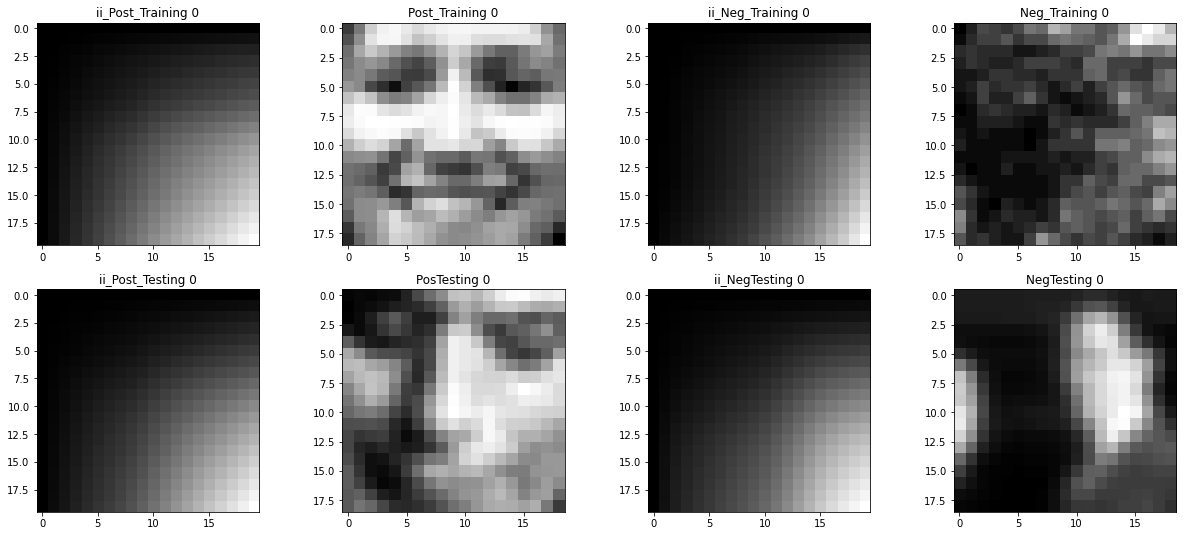

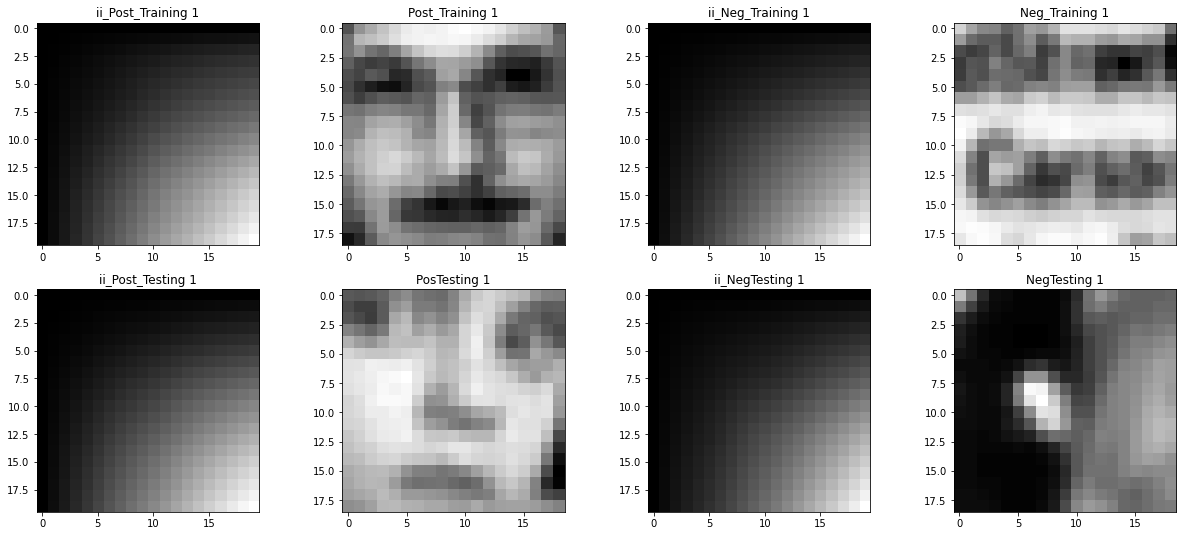

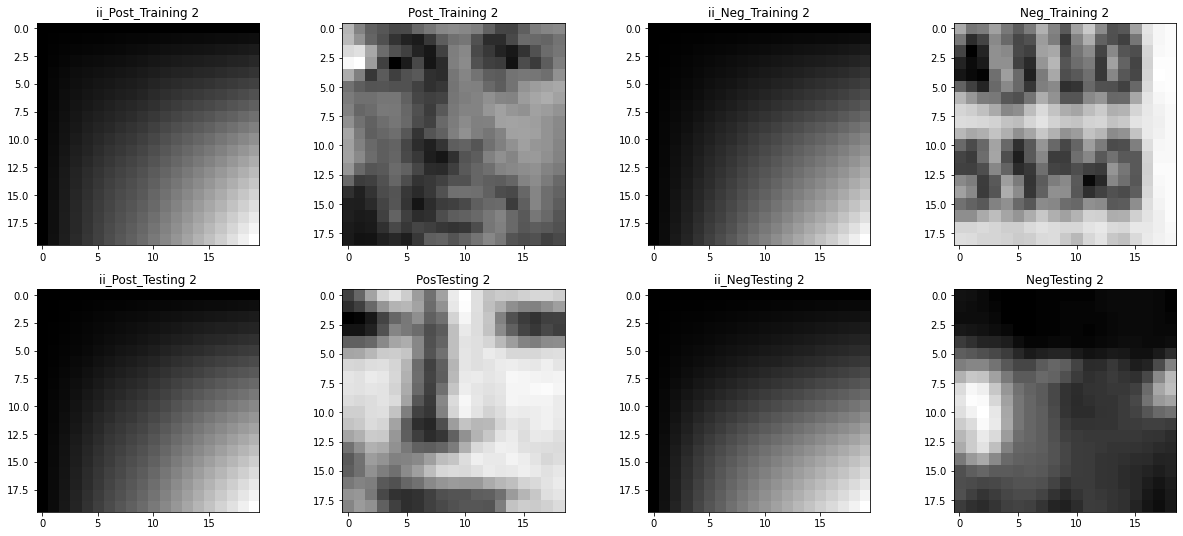

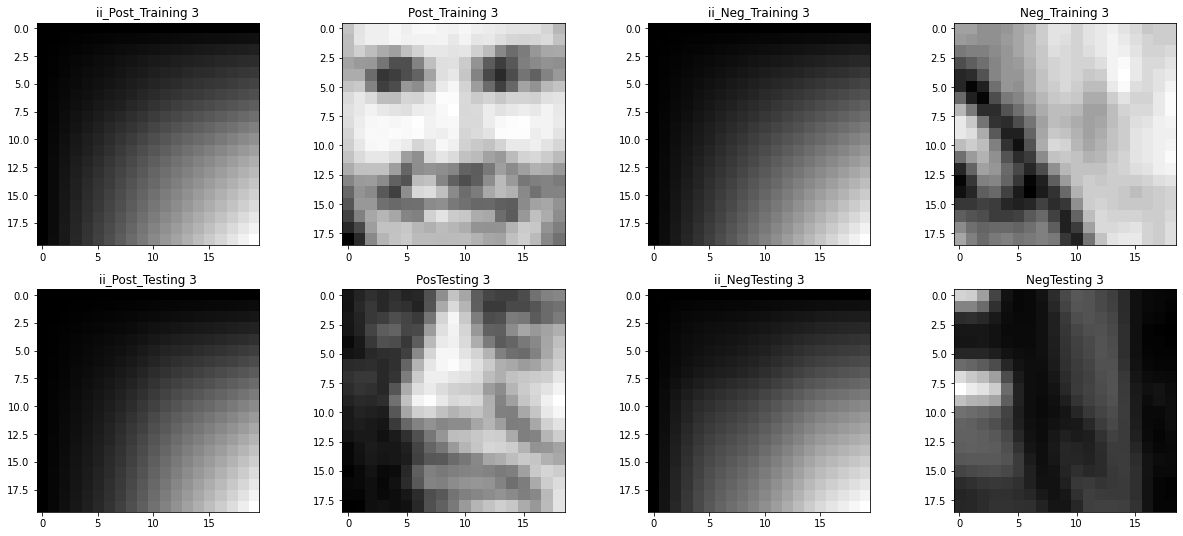

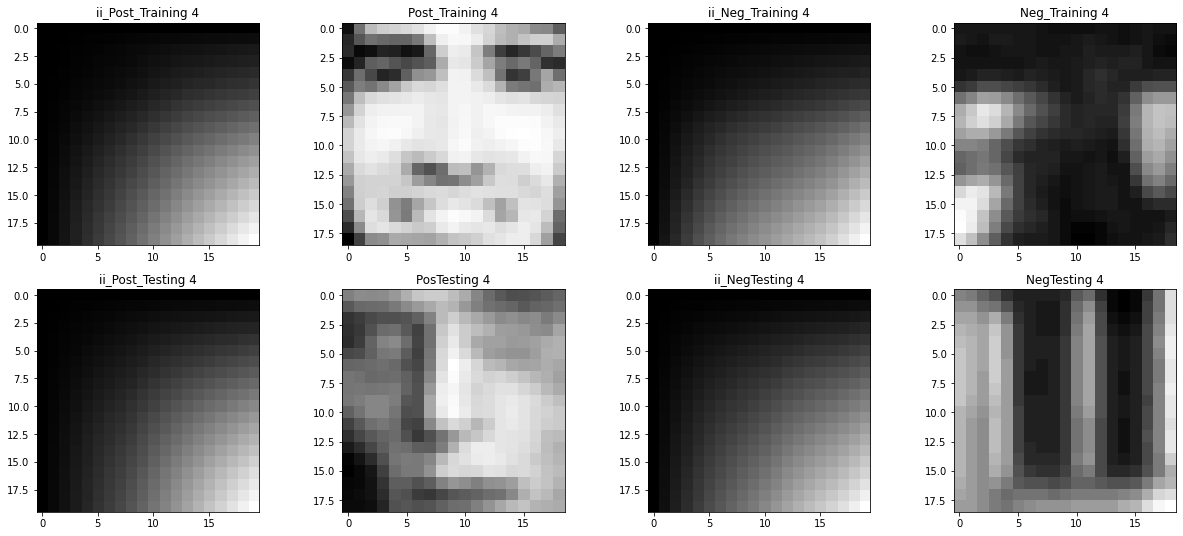

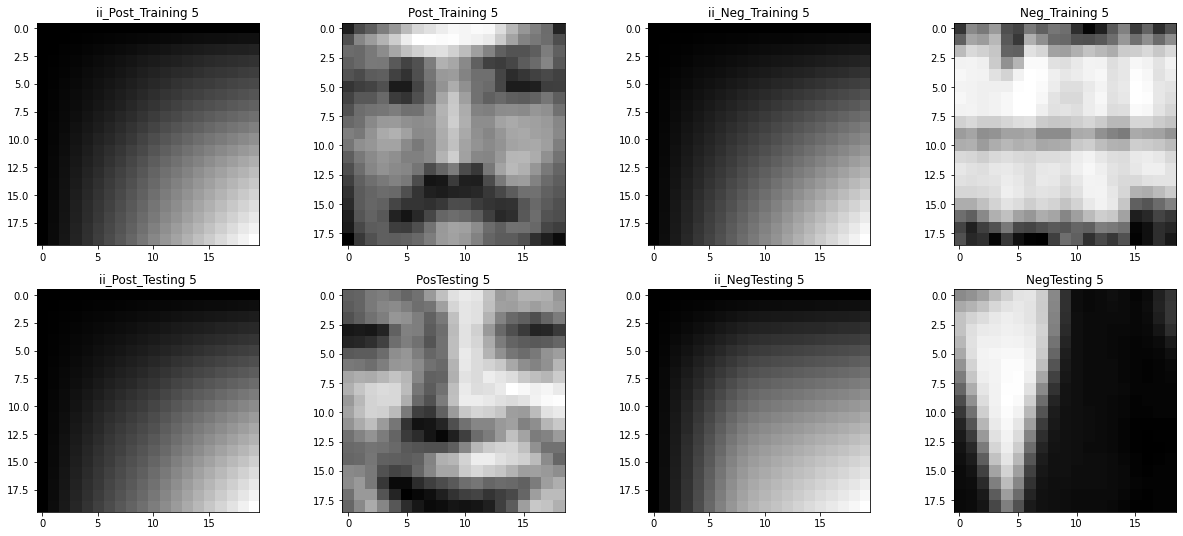

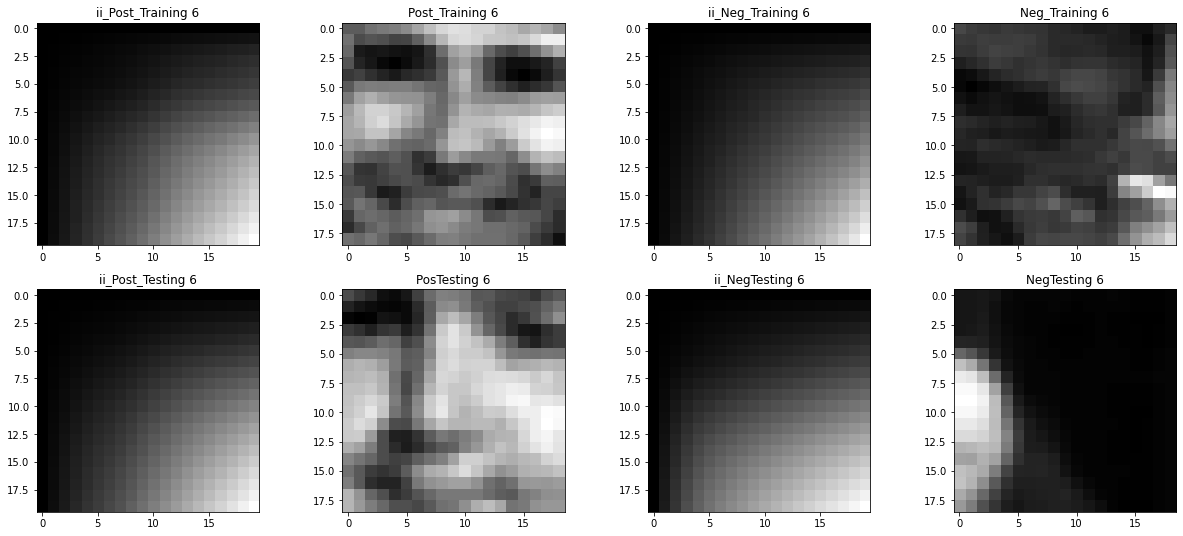

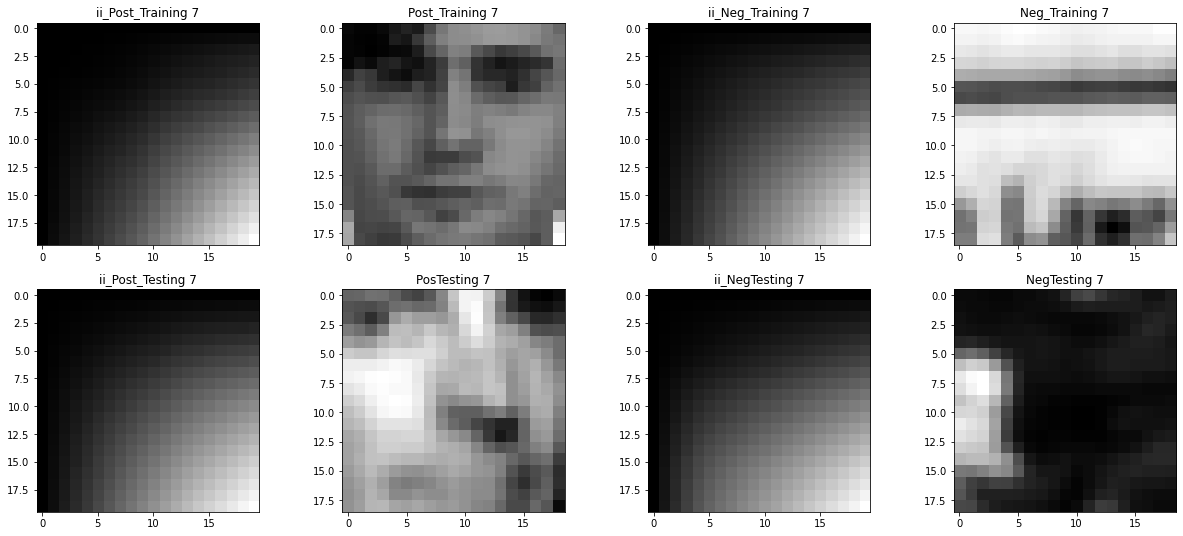

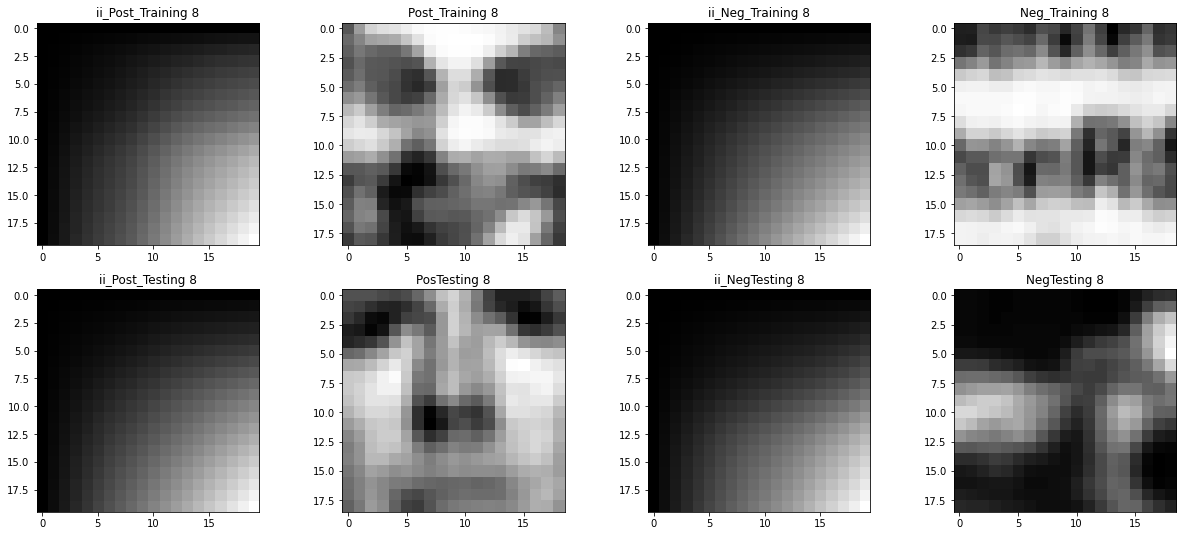

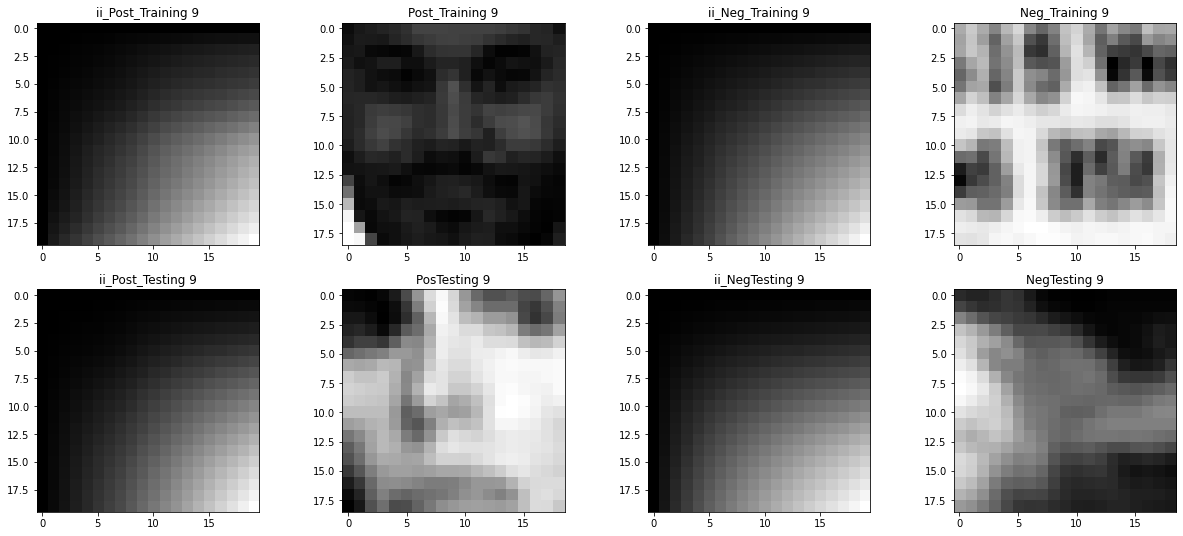

In [ ]:
# solution
i=0
for i in range(0,10):

  plt.figure(figsize=(21,9))

  plt.subplot(2,4,1)
  plt.title(f'ii_Post_Training {i}')
  plt.imshow(ii_Post_Training[i], cmap='gray'  )

  plt.subplot(2,4,2)
  plt.title(f'Post_Training {i}')
  plt.imshow(Post_Training[i], cmap='gray' )



  plt.subplot(2,4,3)
  plt.title(f'ii_Neg_Training {i}')
  plt.imshow(ii_Neg_Training[i], cmap='gray' )

  plt.subplot(2,4,4)
  plt.title(f'Neg_Training {i}')
  plt.imshow(Neg_Training[i], cmap='gray'  )

  plt.subplot(2,4,5)
  plt.title(f'ii_Post_Testing {i}')
  plt.imshow(ii_PosTesting[i], cmap='gray')

  plt.subplot(2,4,6)
  plt.title(f'PosTesting {i}')
  plt.imshow(PosTesting[i], cmap='gray')

  plt.subplot(2,4,7)
  plt.title(f'ii_NegTesting {i}')
  plt.imshow(ii_NegTesting[i], cmap='gray')

  plt.subplot(2,4,8)
  plt.title(f'NegTesting {i}')
  plt.imshow(NegTesting[i], cmap='gray')
  i = i+1
  plt.show()

### Exercise #4

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [ ]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [ ]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [ ]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    
    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
              for x in range (img_width - feature_width):
                for y in range (img_height -  feature_height):
                  features.append(HaarLikeFeature(feature,(x,y),feature_width, feature_height,0,1))
                  features.append(HaarLikeFeature(feature,(x,y), feature_width, feature_height,0,-1))


                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Haar-like features:', time.time()-t0)
    return features

### Exercise #5

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [ ]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
# solution
%%time
# train the model
classifiers = learn(ii_Post_Training, ii_Neg_Training, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)


Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.004799365997314453
Calculating scores for images..
	Time needed for calculating scores: 335.8131353855133
Selecting classifiers..
	Time needed for Selecting Classifiers: 45.93252992630005 

CPU times: user 2min 36s, sys: 7.58 s, total: 2min 43s
Wall time: 6min 21s


### Exercise #6

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [ ]:
# solution
def ensemble_vote(int_img, classifiers):   #Return a 1 if the votes of the classifiers is positive 
                                           #and a zero otherwise
  votes = []
  for classifier in classifiers:
    votes.append(classifier.get_vote(int_img))
    
  if sum(votes) >= 0:   # Return 1 if the value is positive
    return 1
  else:                 # Return 0 if the value is negative
    return 0  




def ensemble_vote_all(int_imgs,classifiers):
  votes_int_imgs = []

  for IntegralImage in int_imgs:
    votes_int_imgs.append(ensemble_vote(IntegralImage,classifiers))
  return votes_int_imgs


*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [ ]:
# solution
TrainingPositive = ensemble_vote_all(ii_Post_Training, classifiers)
TrainingNegative = ensemble_vote_all(ii_NegTesting, classifiers)

TestPositive = ensemble_vote_all(ii_PosTesting,classifiers)
TestNegative = ensemble_vote_all(ii_NegTesting,classifiers)

Train_Positive_Count = TrainingPositive.count(1)
Train_Negative_Count = TrainingNegative.count(1)
Test_Positive_Count = TestPositive.count(1)
Test_Negative_Count = TestNegative.count(1)


Train_Positive_Total = len(TrainingPositive)
Train_Negative_Total = len(TrainingNegative)
Test_Positive_Total = len(TestPositive)
Test_Negative_Total = len(TestNegative)



Accuracy_Train_Positive = (Train_Positive_Count/Train_Positive_Total) * 100
Accuracy_Train_Negative = (Train_Negative_Count/Train_Negative_Total) * 100
Accuracy_Test_Positive = (Test_Positive_Count/Test_Positive_Total) * 100
Accuracy_Test_Negative = (Test_Negative_Count/Test_Negative_Total) * 100


print('Train results:')
print(f'Correctetly identified Faces : {Train_Positive_Count}/{Train_Positive_Total} --> {Accuracy_Train_Positive}')
print(f'Correctetly identified non-Faces: {Train_Negative_Count}/{Train_Negative_Total} --> {Accuracy_Train_Negative}')

print('Test results:')
print(f'Correctetly identified Faces: {Test_Positive_Count}/{Test_Positive_Total} --> {Accuracy_Test_Positive}')
print(f'Correctetly identified non-Faces: {Test_Negative_Count}/{Test_Negative_Total} --> {Accuracy_Test_Negative}')



Train results:
Correctetly identified Faces : 2129/2429 --> 87.64923836969946
Correctetly identified non-Faces: 54/128 --> 42.1875
Test results:
Correctetly identified Faces: 299/472 --> 63.347457627118644
Correctetly identified non-Faces: 54/128 --> 42.1875


### Exercise #7

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [ ]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
# solution

%%time 

classifiers2 = learn(ii_Post_Training, ii_Neg_Training, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)


Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.008086204528808594
Calculating scores for images..
	Time needed for calculating scores: 339.31352138519287
Selecting classifiers..
	Time needed for Selecting Classifiers: 458.51366782188416 

CPU times: user 9min 28s, sys: 8.64 s, total: 9min 37s
Wall time: 13min 17s


In [ ]:
# solution
TrainingPositive2 = ensemble_vote_all(ii_Post_Training, classifiers2)
TrainingNegative2 = ensemble_vote_all(ii_NegTesting, classifiers2)

TestPositive2 = ensemble_vote_all(ii_PosTesting,classifiers2)
TestNegative2 = ensemble_vote_all(ii_NegTesting,classifiers2)

Train_Positive_Count2 = TrainingPositive2.count(1)
Train_Negative_Count2 = TrainingNegative2.count(1)
Test_Positive_Count2 = TestPositive2.count(1)
Test_Negative_Count2 = TestNegative2.count(1)


Train_Positive_Total2 = len(TrainingPositive2)
Train_Negative_Total2 = len(TrainingNegative2)
Test_Positive_Total2 = len(TestPositive2)
Test_Negative_Total2 = len(TestNegative2)



Accuracy_Train_Positive2 = (Train_Positive_Count2/Train_Positive_Total2) * 100
Accuracy_Train_Negative2 = (Train_Negative_Count2/Train_Negative_Total2) * 100
Accuracy_Test_Positive2 = (Test_Positive_Count2/Test_Positive_Total2) * 100
Accuracy_Test_Negative2 = (Test_Negative_Count2/Test_Negative_Total2) * 100


print('Train results:')
print(f'Correctetly identified Faces : {Train_Positive_Count2}/{Train_Positive_Total2} --> {Accuracy_Train_Positive2}')
print(f'Correctetly identified non-Faces: {Train_Negative_Count2}/{Train_Negative_Total2} --> {Accuracy_Train_Negative2}')

print('Test results:')
print(f'Correctetly identified Faces: {Test_Positive_Count2}/{Test_Positive_Total2} --> {Accuracy_Test_Positive2}')
print(f'Correctetly identified non-Faces: {Test_Negative_Count2}/{Test_Negative_Total2} --> {Accuracy_Test_Negative2}')

Train results:
Correctetly identified Faces : 2239/2429 --> 92.17785096747633
Correctetly identified non-Faces: 22/128 --> 17.1875
Test results:
Correctetly identified Faces: 267/472 --> 56.567796610169495
Correctetly identified non-Faces: 22/128 --> 17.1875


In [ ]:
inproveTrainP = Accuracy_Train_Positive/Accuracy_Train_Positive2
inproveTrainN = Accuracy_Train_Negative/Accuracy_Train_Negative2

inproveTestP = Accuracy_Test_Positive/Accuracy_Test_Positive2
inproveTestN = Accuracy_Test_Negative/Accuracy_Test_Negative2

print('The train results was improveds as:')
print(f'In train positive: {inproveTrainP}')
print(f'In train negative: {inproveTrainN}')

print('The test results was improves as:')
print(f'In test positive: {inproveTestP}')
print(f'In test negative: {inproveTestN}')


The train results was improveds as:
In train positive: 0.9508709245198749
In train negative: 2.4545454545454546
The test results was improves as:
In test positive: 1.1198501872659175
In test negative: 2.4545454545454546


*   Discuss if the classification results improved in the train data.


**Solution**

*It is observed that the test results are lower than in training. One of the possibilities when this happens is due to the number of inputs we have to perform the test, our model probably has overffiting.*

...

### Exercise #8

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [ ]:
# solution
#First function
def ensemble_vote_t(int_img, classifiers, threshold):   #returns the final decision of a list of 
                                                      #classifiers for a given threshold
  votes = []
  for classifier in classifiers:
    votes.append(classifier.get_vote(int_img)) 
  if sum(votes) >= threshold:   # Return Threshold if the value is positive
    return 1
  else:                 # Return 0 if the value is negative
    return 0    

#Second function
def ensemble_vote_all_t(int_imgs, classifiers, threshold):
  votes = []
  for ii in int_imgs:
    votes.append(ensemble_vote_t(ii, classifiers, threshold))
  return votes



*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [ ]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:

%%time 

classifiersT = learn(ii_Post_Training, ii_Neg_Training, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)


Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.008099555969238281
Calculating scores for images..
	Time needed for calculating scores: 334.35427737236023
Selecting classifiers..
	Time needed for Selecting Classifiers: 455.2770390510559 

CPU times: user 9min 23s, sys: 9.18 s, total: 9min 33s
Wall time: 13min 9s


In [ ]:
# solution

#For training data
TrainingPositive2 = ensemble_vote_all(ii_Post_Training, classifiersT)
TrainingNegative2 = ensemble_vote_all(ii_NegTesting, classifiersT)
#For testing data
TestPositive2 = ensemble_vote_all(ii_PosTesting,classifiersT)
TestNegative2 = ensemble_vote_all(ii_NegTesting,classifiersT)
#Threshold
thresholds = np.array([x for x in range(-5,5,1)])/10.

#Acuracy
#Save variables to plot
AccuracyTrainPositiveP = []
AccuracyTrainNegativeP = []
AccuracyTestPositiveP = []
AccuracyTestNegativeP = []


for threshold in thresholds:

  #For training data
  TrainingPositiveT = ensemble_vote_all_t(ii_Post_Training, classifiersT,threshold)
  TrainingNegativeT = ensemble_vote_all_t(ii_NegTesting, classifiersT,threshold)
  #For testing data
  TestPositiveT = ensemble_vote_all_t(ii_PosTesting,classifiersT,threshold)
  TestNegativeT = ensemble_vote_all_t(ii_NegTesting,classifiersT,threshold)


  #Total threshold
  TrainingPositiveT_total = len(TrainingPositiveT)
  TrainingNegativeT_total = len(TrainingNegativeT)
  TestPositiveT_total = len(TestPositiveT)
  TestNegativeT_total = len(TestNegativeT)
  #Count all
  TrainingPositiveT_count = TrainingPositiveT.count(1)
  TrainingNegativeT_count = TrainingNegativeT.count(1)
  TestPositiveT_count = TestPositiveT.count(1)
  TestNegativeT_count = TestNegativeT.count(1)

  
  AccuracyTrainPositiveP.append(Accuracy_Train_PositiveT)
  Accuracy_Train_PositiveT = (TrainingPositiveT_count/TrainingPositiveT_total) * 100

  AccuracyTrainNegativeP.append(Accuracy_Train_NegativeT)
  Accuracy_Train_NegativeT = (TrainingNegativeT_count/TrainingNegativeT_total) * 100

  AccuracyTestPositiveP.append(Accuracy_Test_PositiveT)
  Accuracy_Test_PositiveT = (TestPositiveT_count/TestPositiveT_total) * 100

  AccuracyTestNegativeP.append(Accuracy_Test_NegativeT)
  Accuracy_Test_NegativeT = (TestNegativeT_count/TestNegativeT_total) * 100 

  print(f'Threshold: {threshold}')

  print('Train results:')
  print(f'Correctetly identified Faces : {TrainingPositiveT_count}/{TrainingPositiveT_total} --> {Accuracy_Train_PositiveT}')
  print(f'Correctetly identified non-Faces: {TrainingNegativeT_count}/{TrainingNegativeT_total} --> {Accuracy_Train_NegativeT}')

  print('Test results:')
  print(f'Correctetly identified Faces: {TestPositiveT_count}/{TestPositiveT_total} --> {Accuracy_Test_PositiveT}')
  print(f'Correctetly identified non-Faces: {TestNegativeT_count}/{TestNegativeT_total} --> {Accuracy_Test_NegativeT}')
  print('\n\n')





Threshold: -0.5
Train results:
Correctetly identified Faces : 2371/2429 --> 97.61218608480856
Correctetly identified non-Faces: 43/128 --> 33.59375
Test results:
Correctetly identified Faces: 357/472 --> 75.63559322033898
Correctetly identified non-Faces: 43/128 --> 33.59375



Threshold: -0.4
Train results:
Correctetly identified Faces : 2361/2429 --> 97.20049403046521
Correctetly identified non-Faces: 41/128 --> 32.03125
Test results:
Correctetly identified Faces: 342/472 --> 72.45762711864407
Correctetly identified non-Faces: 41/128 --> 32.03125



Threshold: -0.3
Train results:
Correctetly identified Faces : 2328/2429 --> 95.84191025113216
Correctetly identified non-Faces: 33/128 --> 25.78125
Test results:
Correctetly identified Faces: 332/472 --> 70.33898305084746
Correctetly identified non-Faces: 33/128 --> 25.78125



Threshold: -0.2
Train results:
Correctetly identified Faces : 2314/2429 --> 95.26554137505147
Correctetly identified non-Faces: 28/128 --> 21.875
Test results:
Cor

*   Make a bar plot for 1-4. In the x axis write the threshold value.

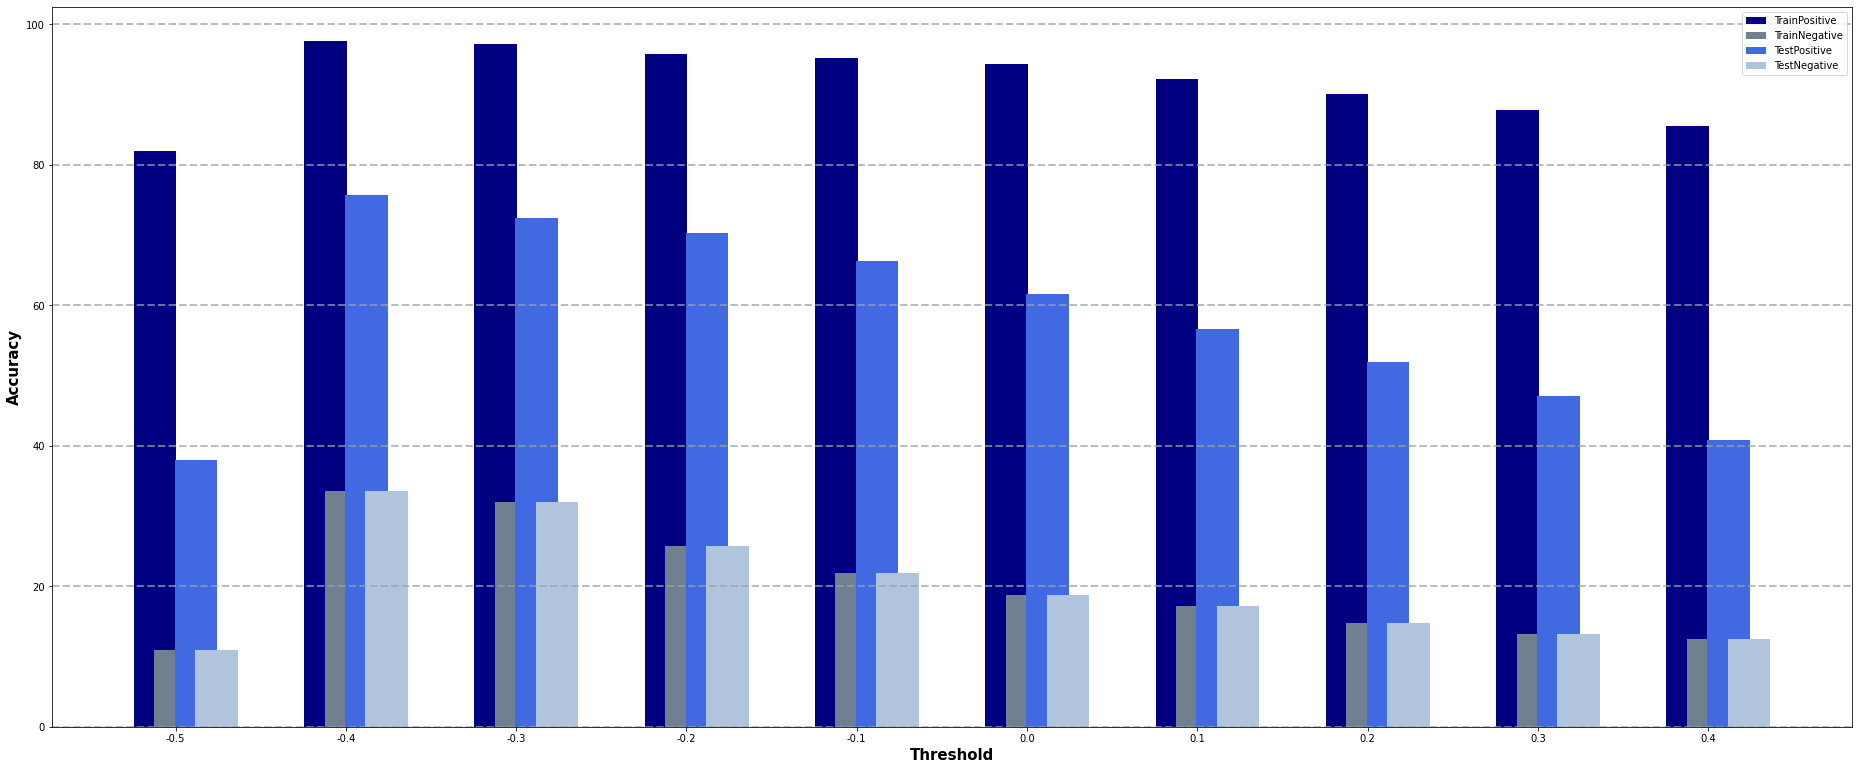

[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]


In [ ]:
# solution

Bw = 0.12
labelsx = [str(thr) for thr in thresholds]
fig = plt.figure(figsize=(25,10))

br1 = np.arange(len(AccuracyTrainPositiveP))
br2 = [x + Bw for x in br1]
br3 = [x + Bw for x in br2]
br4 = [x + Bw for x in br3]


ax = fig.add_axes([0,0,1,1])
ax.bar(br1, AccuracyTrainPositiveP, color = 'navy', width = 0.25,label='TrainPositive')
ax.bar(br2, AccuracyTrainNegativeP, color = 'slategrey', width = 0.25,label='TrainNegative')
ax.bar(br3, AccuracyTestPositiveP , color = 'royalblue', width = 0.25,label='TestPositive')
ax.bar(br4, AccuracyTestNegativeP, color = 'lightsteelblue', width = 0.25,label='TestNegative')

plt.xlabel('Threshold', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks([r + Bw for r in range(len(labelsx))], labelsx)

plt.legend()

plt.show()


print(thresholds)


*   Discuss what happens when you increase the threshold value.

**Solution**

*It can be seen in the previous figure that when the threshold increases, the precision percentage decreases for the train and test datasets.*

...

# Face Recognition using PCA


In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

*   Loading the dataset

In [ ]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


*   Creating training and testing set

In [ ]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Number of classes in Train set:', np.unique(y_train).shape[0])

Train data shape: (966, 1850)
Test data shape: (322, 1850)
Number of classes in Train set: 7


### Exercise #1: PCA Computation
*   Compute a PCA (eigenfaces) on the face dataset
    *   *Set* number of components to 100

In [ ]:
# solution

pca = PCA(n_components=100)
pca.fit(X_train)

PCA(n_components=100)

*   Reshape the components output of pca to obtain the eigen faces

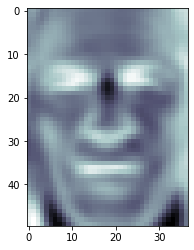

In [ ]:
# solution
EigenFace = pca.components_.reshape((100,h,w))
plt.imshow(EigenFace[7],
           cmap=plt.cm.bone)

*   Project the training and testing faces data on the orthonormal basis

In [ ]:
# solution
PCA_Train = pca.fit_transform(X_train)
PCA_Test = pca.fit_transform(X_test)


*   Plot the most significative eigenfaces (Show the top 12 eigenfaces) as a matplotlib

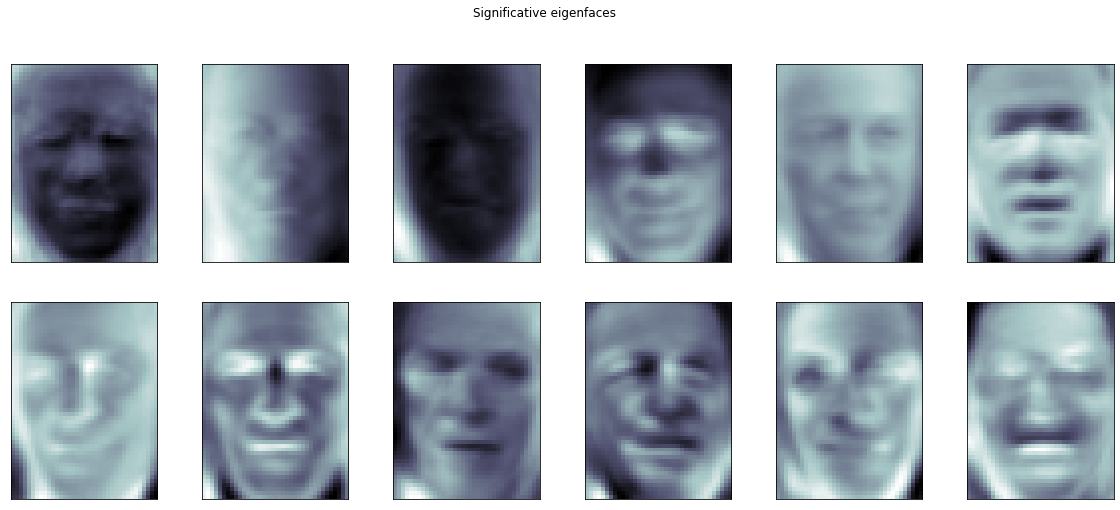

In [ ]:
# solution

fig = plt.figure(figsize=(20, 8))
plt.suptitle('Significative eigenfaces')
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(EigenFace[i],
              cmap=plt.cm.bone)

*   Show the total percentage of variance explained by the selected components of the PCA.


In [ ]:
# solution
variance = pca.explained_variance_ratio_*100
print(variance)

[17.549767   15.184823    7.9896393   6.5222077   5.1209135   3.5080447
  2.5678897   2.1910043   2.189457    1.9925859   1.5026835   1.4680514
  1.3462336   1.2221345   1.0879617   1.051892    1.0132822   0.97811604
  0.87946665  0.77614725  0.7428305   0.69470334  0.6731477   0.63063425
  0.59822553  0.5712738   0.5378892   0.5088528   0.50549346  0.48282817
  0.43254453  0.41564247  0.3976963   0.39017564  0.37701184  0.36053476
  0.34979996  0.33487278  0.3174563   0.31056175  0.30583736  0.28396934
  0.27802792  0.273563    0.26749066  0.2655245   0.24842346  0.23771475
  0.23739673  0.23116323  0.22723645  0.22052822  0.21309972  0.2095972
  0.20099269  0.19642735  0.19101535  0.1847163   0.18197231  0.17600726
  0.1743374   0.17129068  0.16789657  0.16484146  0.15809953  0.15599975
  0.14967823  0.1467556   0.14345726  0.14322498  0.13902913  0.13468617
  0.13337351  0.13318418  0.12680252  0.12334186  0.12079986  0.11946095
  0.11870654  0.11574125  0.11237983  0.11169888  0.10

*   What are the shortcomings of PCA?

**Solution**

*In this case, the principal components analysis also called as linear combination of features has as one of the problems its complex way to interpret and it is necessary to have the user concludes the relevant features.*

...

### Exercise #2: k-NN Classification

*   Train a k-nearest neighbor model with the eigenfaces using the default parameters

In [ ]:
# solution
kneighbor = KNeighborsClassifier()
kneighbor.fit(X_train, y_train)

KNeighborsClassifier()

*   Predict the test data using the trained classifier

In [ ]:
# Quantitative evaluation of the model quality on the test set
PredictionTestData = kneighbor.predict(X_test)
PredictionTestData

array([3, 3, 3, 3, 3, 3, 6, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 0,
       3, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 6,
       3, 1, 6, 3, 0, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 1, 1, 4, 1, 0, 3,
       1, 6, 1, 3, 1, 6, 1, 3, 3, 2, 1, 3, 1, 3, 3, 0, 3, 3, 3, 2, 3, 3,
       6, 3, 3, 6, 3, 2, 1, 3, 1, 1, 3, 6, 3, 3, 3, 3, 3, 4, 3, 3, 5, 3,
       3, 1, 3, 3, 4, 3, 0, 3, 1, 3, 1, 3, 3, 0, 3, 4, 4, 3, 1, 1, 3, 3,
       6, 3, 3, 2, 3, 3, 3, 1, 0, 2, 5, 1, 3, 5, 1, 3, 2, 1, 3, 1, 3, 3,
       4, 3, 1, 3, 2, 3, 6, 5, 3, 1, 3, 1, 5, 1, 1, 3, 3, 1, 3, 1, 3, 3,
       3, 2, 2, 3, 1, 3, 2, 1, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 6, 3, 3, 6,
       3, 3, 5, 2, 3, 1, 3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 2,
       1, 3, 1, 1, 1, 2, 3, 3, 0, 3, 3, 2, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1,
       2, 3, 3, 1, 3, 1, 0, 6, 4, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 1, 1,
       3, 3, 1, 1, 3, 6, 1, 1, 3, 3, 6, 2, 3, 3, 0, 6, 1, 3, 3, 3, 1, 3,
       3, 5, 3, 3, 1, 3, 5, 0, 3, 3, 4, 5, 3, 3, 3,

### Exercise #3: Quantitative results

*   Compute accuracy, classification report and confusion matrix of the trained classifier

In [ ]:
# solution
Accuracy = accuracy_score(y_test, PredictionTestData)* 100
print(f"Accuracy is {Accuracy:.2f}%")


Accuracy is 59.63%


In [ ]:
# solution
ClassificationReport = classification_report(y_test, PredictionTestData)
print(ClassificationReport)

              precision    recall  f1-score   support

           0       0.27      0.31      0.29        13
           1       0.57      0.62      0.59        60
           2       0.42      0.41      0.42        27
           3       0.66      0.82      0.73       146
           4       0.44      0.16      0.24        25
           5       0.56      0.33      0.42        15
           6       0.67      0.33      0.44        36

    accuracy                           0.60       322
   macro avg       0.51      0.42      0.45       322
weighted avg       0.59      0.60      0.58       322



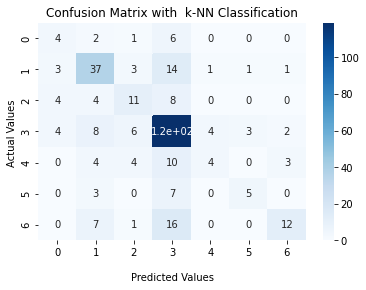

In [ ]:
# solution
from sklearn.metrics import ConfusionMatrixDisplay 
import seaborn as sns

ConfusionMatrix = confusion_matrix(y_test, PredictionTestData)

ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with  k-NN Classification');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Display the visualization of the Confusion Matrix.
plt.show()


*   Explain the measures showed in the classification report.
*   Discuss the obtained classification results, both the quantitative as well as the qualitative results.

**Solution**

*As shown in the report we have four variables, precision, recall, f1-score and support. Precision is the quality of the data while support is the amount of data that was cluterized and f1-scored is the weighted average score.

We can see that precision has a higher value than quality, taking it almost 9% higher. A curiosity is the average weight that are distributed almost in the same range being 58.59 and 60.*

...

### Exercise #4

*   How is the optimal value of 'k' found?

**Solution**

*k = square_root(N)*

...

*   Use GridSearch to find the optimal value of 'k'.
    *   *Hint: GridSearchCV is available in sklearn.model_selection*
*   What is the accuracy of the best estimator?

In [ ]:
# solution
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# define a range 
grid_range = list(range(1, 31))
param_grid = dict(n_neighbors=grid_range)
# Parameters of pipelines can be set using ‘__’ separated parameter names:
search = GridSearchCV(kneighbor, param_grid, n_jobs=-1)
print(search.fit(X_train, y_train))

kmeans = KNeighborsClassifier()
gsc = GridSearchCV(kmeans, param_grid, scoring='accuracy')
gsc.fit(X_train, y_train)
predicted = gsc.predict(X_test)


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]})


In [ ]:
print(f"Accuracy estimated: {search.best_score_}")

Accuracy estimated: 0.5538272528176915


### Exercise #5: Qualitative evaluation

*   Plot some of the prediction images using matplotlib subplots (4 x 4). Show the true label and predicted label as the title of each sub plot.

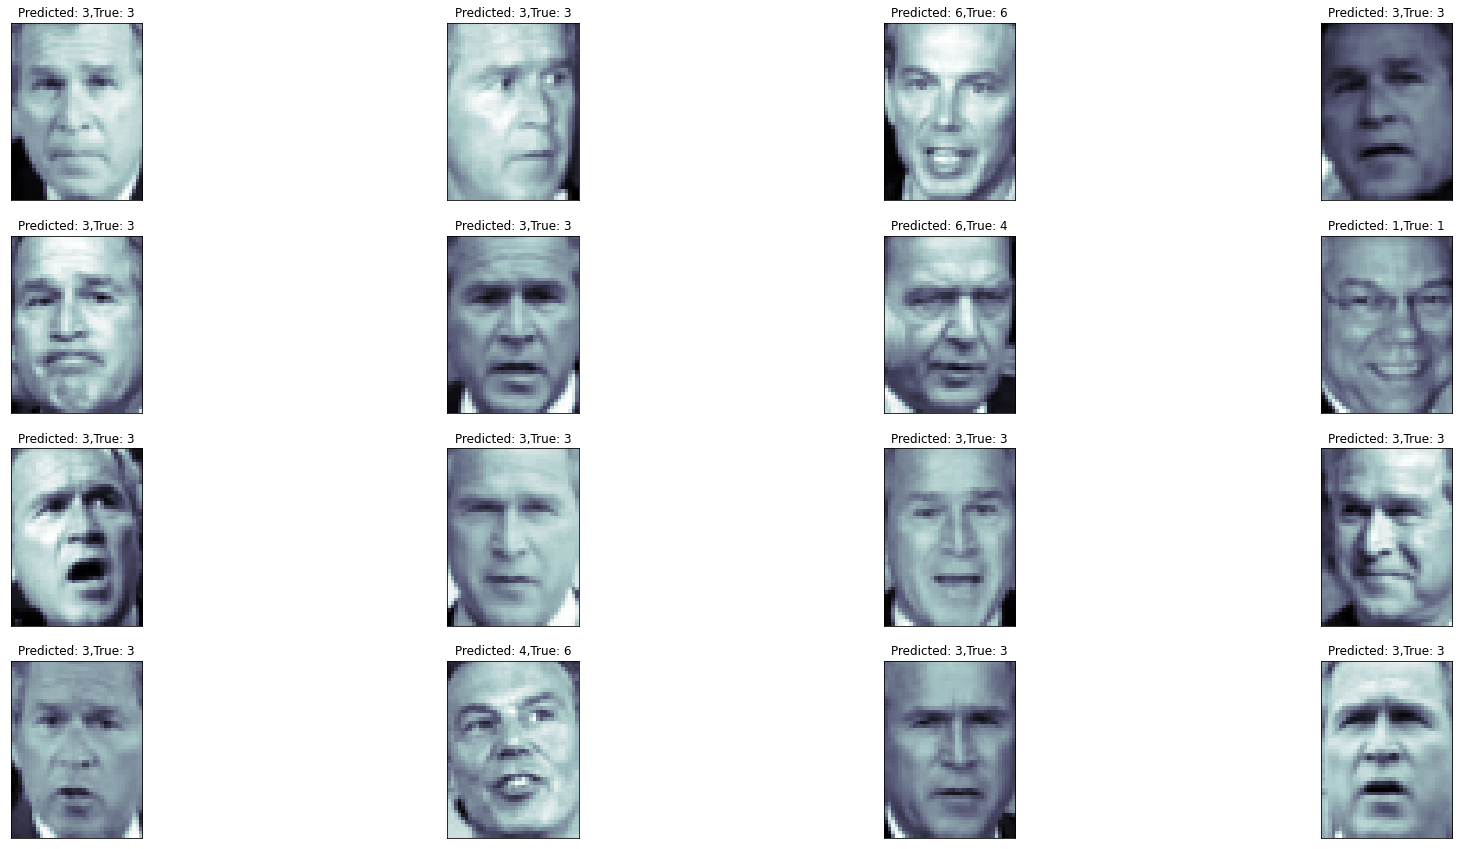

In [ ]:
# solution
fig = plt.figure(figsize=(30, 15))
test_images = X_test.reshape(X_test.shape[0], h,w)
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(test_images[i],
              cmap=plt.cm.bone)
    ax.set_title(f"Predicted: {predicted[i]},True: {y_test[i]}")

*   What are the disadvantages of using kNN

**Solution**

*  - K-NN slow algorithm and its speed decreas very fast in small datasets
   - Outlier sensitivity. In this case, we can perceive that it is very sensitive to unsequenced characteristics.
*

...


---

# **End of P3: Face Detection and Recognition**
Deadline for P3 submission in CampusVirtual is: **Monday, the 22nd of November, 2021**